# DS4440 - Practical Neural Networks
## Understanding Generative Adversarial Network (GAN)

___
**Instructor** : Prof. Steve Schmidt <br/>
**Teaching Assistants** : Vishwajeet Hogale (hogale.v@northeastern.edu) | Chaitanya Agarwal (agarwal.cha@northeastern.edu)

## Problem Statement  
In this notebook, we'll explore **Generative Adversarial Networks (GANs)** using the **Fashion MNIST dataset**. GANs are a class of deep learning models designed to generate new, realistic data by learning the underlying patterns in a dataset.

### We will:  
- Build a **GAN** to generate synthetic Fashion MNIST images  
- Understand how a **Generator** and **Discriminator** work together in an adversarial setup  
- Explore how GANs can be used for **data augmentation** and **image synthesis**  

### What makes GANs special?  
- They consist of two neural networks:  
  - **Generator**: Learns to create realistic images  
  - **Discriminator**: Learns to distinguish real images from generated ones  
- GANs are **unsupervised**, meaning they don't require labeled data  
- They are widely used in **image generation, style transfer, and creative AI applications**  


## 0. Setup and Load libraries

The below cell helps you download all the necessary libraries or packages required to run this notebook without running into any errors.

In [4]:
! pip install -r requirements.txt

## 1. Data Gathering

### **About the Dataset**

The Fashion MNIST dataset consists of **70,000 labeled grayscale images**, each with a resolution of **28x28 pixels and 10 distinct classes**. This structured dataset allows us to experiment with building and training models, tuning hyperparameters, and evaluating performance.


Each example in the dataset is assigned to one of the following labels:

0 T-shirt/top<br/>
1 Trouser<br/>
2 Pullover<br/>
3 Dress<br/>
4 Coat<br/>
5 Sandal<br/>
6 Shirt<br/>
7 Sneaker<br/>
8 Bag<br/>
9 Ankle boot
<br/>
<br/>

**Dataset Source**
<br/>
The Fashion MNIST Dataset is a very popular dataset, which is already present in the torch library. What we're going to do is that we will fetch this dataset from torch and download it in our current working directory.
<br/><br/>

**What is the below cell doing?**<br/>
The below cell downloads the Fashion MNIST images in the current working directory. Torch offers **60,000** images as training images and **10,000** images as testing images. 



In [5]:
from torchvision import datasets, transforms

# Convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors (values between 0 and 1)
    # transforms.Normalize((0.5,), (0.5,))  # Center the data around 0 (-1 to 1)
])

# Load Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)


100%|██████████| 26421880/26421880 [00:24<00:00, 1067409.93it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 266587.88it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4787871.62it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6766617.67it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### In this notebook, we will pass the images through the neural network. But, there are a few extra steps that needs to be performed. 

#### Setting up Data Loaders
##### What are dataloaders ? 
Data Loaders help us organize and load our data into our model in small chunks, so the model can learn from the data one batch at a time. 

##### Why do we need them ? 
- **Efficient memory usage**: Load data in small batches instead of all at once.
- **Faster training**: Process data in batches to speed up learning.
- **Shuffling**: Randomize data order to improve model performance.

##### What do they do ? 
- They create several batches of batch_size * (image : label) pairs for the model to learn about patterns in images.

In [6]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Loads the training data in batches of 64 images at a time.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Loads the testing data in batches of 64 images at a time.

#### Visualize an image from a batch

In [7]:
fashion_mnist_classes = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def load_image_from_batch():
    # Get one batch of data from the train_loader
    for images, labels in train_loader:
        # Get the first image from the batch using indexing
        image = images[0]
        label = labels[0]
        break  # Exit the loop after getting the first batch

    # Convert the PIL image to a NumPy array
    image = image[0].numpy()  # Convert the 28x28 image to NumPy array (shape: (28, 28))

    # Display the image using matplotlib
    plt.imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale image
    plt.title("Label: {}".format(fashion_mnist_classes[label.item()]))  # Show the label as the title
    plt.axis('off')  # Hide the axis
    plt.show()

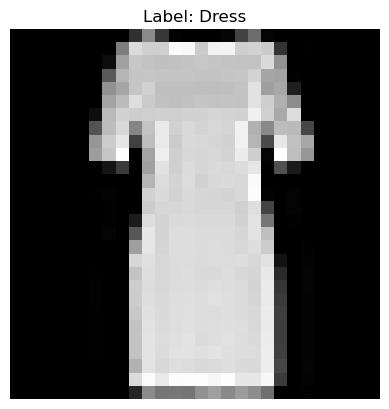

In [9]:
load_image_from_batch()

## 2. Data Wrangling

### Check the size of the training dataset

In [10]:

num_images_train = len(train_dataset)
num_images_test = len(train_dataset)
# Print the number of images in the dataset
print(f"The train dataset has {num_images_train} images")
print(f"The train dataset has {num_images_test} images")


The train dataset has 60000 images
The train dataset has 60000 images


## 3. Model Building

### **Generative Adversarial Networks (GANs)**  

### **About GANs**  

Generative Adversarial Networks (GANs) are a class of deep learning models used for **unsupervised learning**, primarily for tasks like **image generation, data augmentation, and anomaly detection**. GANs consist of two neural networks – a **Generator** and a **Discriminator** – that compete against each other in an adversarial setup. The Generator aims to create realistic data, while the Discriminator attempts to distinguish real data from fake data.  

GANs have been widely used in **image synthesis, style transfer, super-resolution, and even text-to-image generation**.

---

### **Key Components**  

- **Generator**  
  The Generator is a neural network that **takes random noise as input** and generates data (e.g., images) that mimics real data. It consists of fully connected layers or transposed convolutional layers to upsample the random noise into structured outputs. The goal of the Generator is to **fool the Discriminator** into thinking the generated samples are real.  

  Example architecture:  
  ```python
  self.generator = nn.Sequential(
      nn.Linear(100, 256),
      nn.ReLU(),
      nn.Linear(256, 512),
      nn.ReLU(),
      nn.Linear(512, 1024),
      nn.ReLU(),
      nn.Linear(1024, 28*28),
      nn.Tanh()
  )
- Discriminator
  The Discriminator is a binary classifier that determines whether a given input is real (from the training dataset) or fake (generated by the Generator). It consists of convolutional or fully connected layers, followed by activation functions like LeakyReLU to prevent vanishing gradients. The goal of the Discriminator is to correctly classify real and fake images.
  Example architecture:  
    ```python
    self.discriminator = nn.Sequential(
      nn.Linear(28*28, 1024),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(1024, 512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )
- **Latent Space (Noise Vector)**
  tput through the network. The latent space is typically a high-dimensional Gaussian distribution.
- **Adversarial Training (Minimax Game)**
  GANs are trained using a zero-sum game approach:

  - The Generator tries to fool the Discriminator by generating realistic samples.
  - The Discriminator tries to correctly classify real and fake images.
  - Both networks are updated alternately, improving over time.
#### Loss Function (Binary Cross-Entropy or Wasserstein Loss)
  The standard loss function for GANs is the binary cross-entropy (BCE) loss, which measures how well the Discriminator distinguishes real from fake data. Another popular approach is Wasserstein loss (WGANs), which improves stability and training performance.
  - Generator loss:
      ```python
      loss_G = criterion(discriminator(fake_images), real_labels)
  - Discriminator loss
      ```python
      loss_D = criterion(discriminator(real_images), real_labels) + criterion(discriminator(fake_images.detach()), fake_labels)
#### Activation Functions
  - ReLU is used in the Generator’s hidden layers for non-linearity.
  - LeakyReLU is commonly used in the Discriminator to avoid dying neurons.
  - Tanh is used in the Generator's output layer to normalize the generated images to the range [-1,1].
  - Sigmoid is used in the Discriminator’s output to return a probability score.
#### Training the GAN
  - The Discriminator is trained first on real images (label = 1) and fake images (label = 0).
  - The Generator is then trained to fool the Discriminator, using fake images labeled as real.
  - This process is repeated iteratively, leading to improvement in both networks.

#### GAN Training Workflow
1. Generate random noise from a Gaussian distribution.
2. Generate fake images using the Generator.
3. Train the Discriminator using real and fake images.
4. Train the Generator by maximizing the Discriminator’s error.
5. Repeat the process for multiple epochs until the Generator produces realistic samples.

#### Applications of GANs
1. Image Generation: Create realistic images from noise (e.g., StyleGAN, BigGAN).
2. Super-Resolution: Enhance low-resolution images (e.g., SRGAN).
3. Image-to-Image Translation: Convert one image type into another (e.g., Pix2Pix, CycleGAN).
4. Data Augmentation: Generate synthetic training data for machine learning models.
5. Anomaly Detection: Identify outliers by detecting fake-looking data.


In [22]:
# Hyperparameters for GAN training
lr_G = 0.0002  # Learning rate for Generator
lr_D = 0.0002  # Learning rate for Discriminator
epochs = 10  # Number of training epochs
batch_size = 128  # Batch size for training

# Print the chosen hyperparameters
print("GAN Training Hyperparameters:")
print(f"Generator Learning Rate: {lr_G}")
print(f"Discriminator Learning Rate: {lr_D}")
print(f"Batch Size: {batch_size}")
print(f"Number of Epochs: {epochs}")


GAN Training Hyperparameters:
Generator Learning Rate: 0.0002
Discriminator Learning Rate: 0.0002
Batch Size: 128
Number of Epochs: 10


In [23]:
import torch.nn as nn

# Generator Network
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            # Input: N, noise_dim (100) -> N, 256
            nn.Linear(noise_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28*28),
            nn.Tanh()  # Output shape: (N, 784), values between [-1,1]
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 1, 28, 28)  # Reshape to (N, 1, 28, 28) image format


# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Input: N, 1, 28, 28 -> Flattened (N, 784)
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Probability output (real/fake)
        )

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten input images
        return self.model(x)


In [24]:
import torch
import torch.optim as optim
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

In [25]:
# Initialize models
noise_dim = 100
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

## **Training a GAN: Step-by-Step Explanation**

### **1. Understanding the GAN Training Process**
A Generative Adversarial Network (GAN) consists of two competing neural networks:
- **Generator**: Creates fake images from random noise.
- **Discriminator**: Determines if an image is real (from the dataset) or fake (generated).

These two networks **train together** in an adversarial manner, improving each other over time.

---

### **2. Training Workflow**
1. **Initialize the networks**  
   - The **Generator** starts with random noise and learns to generate realistic images.  
   - The **Discriminator** learns to differentiate between real images (from FashionMNIST) and fake ones (from the Generator).

2. **Load the FashionMNIST dataset**  
   - Images are converted to tensors and normalized to values between **-1 and 1** for better training stability.  
   - Data is loaded in **mini-batches** to improve training efficiency.

3. **Training Loop (for multiple epochs)**  
   - Each **epoch** consists of multiple **iterations**, where the GAN learns from batches of images.  
   - For each batch:
   
     **(a) Train the Discriminator**  
     - The Discriminator is given **real images** (labeled as 1) and **fake images** from the Generator (labeled as 0).  
     - It **learns to distinguish real from fake** by minimizing its classification error.  

     **(b) Train the Generator**  
     - The Generator creates **fake images** and tries to **fool the Discriminator**.  
     - Instead of real/fake labels, we tell the Generator that its fake images should be **classified as real (1)**.  
     - The Generator learns to generate **better images** by minimizing the Discriminator’s ability to detect fakes.

4. **Repeat the process for multiple epochs**  
   - Over time, the Generator improves at **creating realistic images**, and the Discriminator improves at **detecting fakes**.

---

### **3. Visualizing Results**
- After every **few epochs**, we generate images from the Generator to **see its progress**.
- Initially, the images look **random and noisy**.
- As training progresses, the Generator **produces clearer images** that resemble FashionMNIST items.

---

### **4. Expected Results**
- **At the start**: The Generator produces completely **random noise**.
- **After some epochs**: The Generator starts producing **shapes that resemble clothes**.
- **Later in training**: The generated images **closely match** real FashionMNIST items (shoes, shirts, etc.).

---



Epoch [1/10] | D Loss: 1.2951 | G Loss: 1.0030


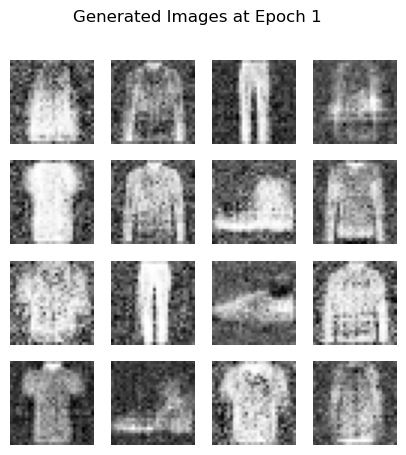

Epoch [2/10] | D Loss: 1.3406 | G Loss: 0.8155


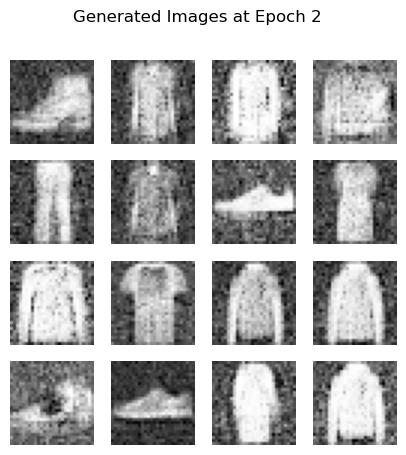

Epoch [3/10] | D Loss: 1.2944 | G Loss: 0.8164


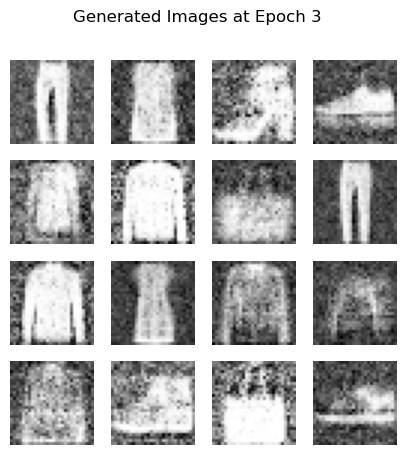

Epoch [4/10] | D Loss: 1.2965 | G Loss: 0.9346


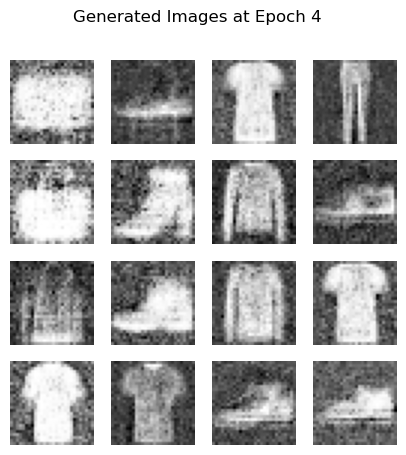

Epoch [5/10] | D Loss: 1.3608 | G Loss: 0.9594


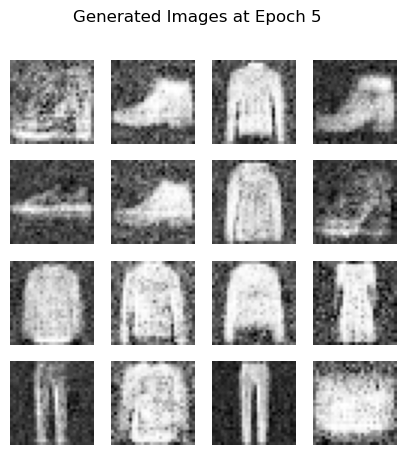

Epoch [6/10] | D Loss: 1.3315 | G Loss: 0.9025


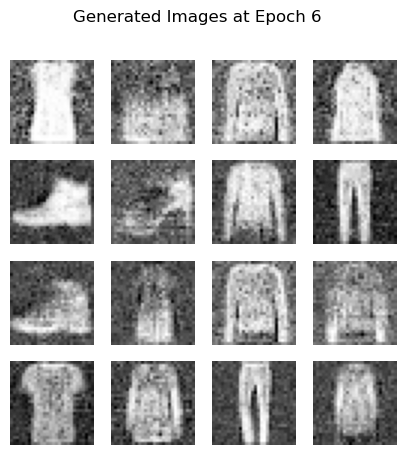

Epoch [7/10] | D Loss: 1.3723 | G Loss: 0.8614


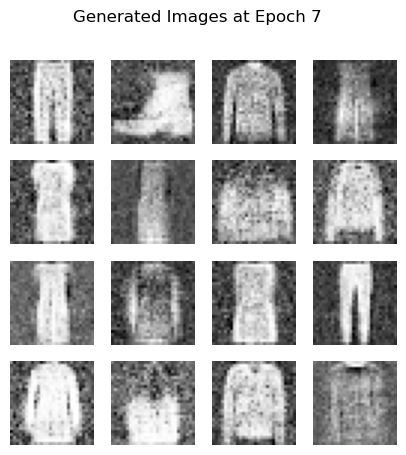

Epoch [8/10] | D Loss: 1.2413 | G Loss: 0.7987


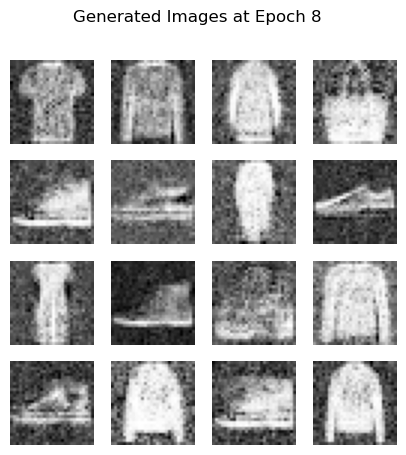

Epoch [9/10] | D Loss: 1.3056 | G Loss: 0.8654


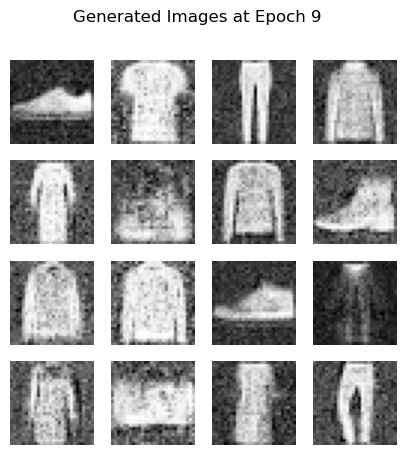

Epoch [10/10] | D Loss: 1.3975 | G Loss: 0.7219


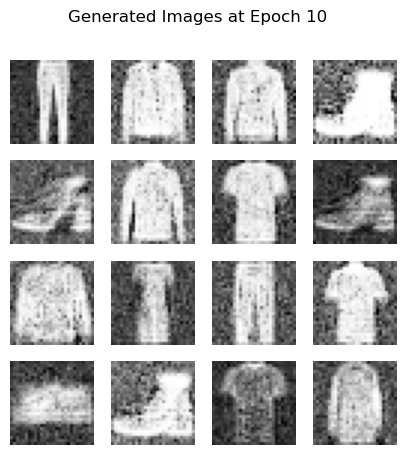

In [28]:
# Function to generate and visualize images
def generate_and_plot_images(epoch, generator, noise_dim, num_images=16):
    noise = torch.randn(num_images, noise_dim).to(device)
    fake_images = generator(noise).cpu().detach().numpy()
    fake_images = (fake_images + 1) / 2.0  # Rescale images to [0,1]

    fig, axes = plt.subplots(4, 4, figsize=(5, 5))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(fake_images[i, 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(f"Generated Images at Epoch {epoch}")
    plt.show()


# Training Function
def train_gan(epochs, train_loader, noise_dim):
    for epoch in range(epochs):
        for real_images, _ in train_loader:
            real_images = real_images.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            batch_size = real_images.size(0)

            # Generate fake images
            noise = torch.randn(batch_size, noise_dim).to(device)
            fake_images = generator(noise)

            # Labels for real (1) and fake (0)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Compute discriminator loss
            real_loss = criterion(discriminator(real_images), real_labels)
            fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()

            # Generate fake images and try to fool discriminator
            noise = torch.randn(batch_size, noise_dim).to(device)
            fake_images = generator(noise)
            g_loss = criterion(discriminator(fake_images), real_labels)  # Trick discriminator into thinking fake is real
            g_loss.backward()
            optimizer_G.step()

        # Print progress
        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

        # Generate and save images every few epochs
        if (epoch + 1) % 1 == 0:
            generate_and_plot_images(epoch + 1, generator, noise_dim)


# Train the GAN
train_gan(epochs, train_loader, noise_dim)

## 4. Other Visualizations